In [1]:
import numpy as np
import pandas as pd
import matplotlib as mplt
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots, show
from matplotlib.patches import Polygon
%matplotlib inline

# Задание № 2 по теме «Задача о распаде разрыва для системы уравнений акустики». Орехов Роман, 471a. Шаблон 2

## Задача:

Рассматривается задача Коши для одномерной системы уравнений акустики:

\begin{equation} 
    \begin{cases} 
        \frac{\partial u}{\partial t} + \frac{1}{ \rho_0} \frac{\partial p}{\partial x} = 0, 
        \\ 
        \frac{\partial p}{\partial t} + \rho_0 c_0^2 \frac{\partial u}{\partial x} = 0, 
    \end{cases} 
\end{equation} 


\begin{equation} 
    u = 
    \begin{cases} 
        u_L , x < 0, 
        \\ 
        u_R, x > 0 
    \end{cases} 
\end{equation} 


\begin{equation} 
    p = 
       \begin{cases} 
        p_L, x < 0, 
        \\ 
        p_R, x > 0 
    \end{cases} 
\end{equation} 

С параметрами $\rho_0 = 0.25,\space c_0 = 2.0,\space u_L = 1.0,\space u_R = 0.0,\space p_L = 5.0,\space p_R = 2.0$ 

## Точное решение:

\begin{cases} 
    u=u_L, \space p=p_L, если \space x < x^* -c_0t 
    \\
    u=u_R, \space p=p_R, если \space x > x^* +c_0t
    \\
    u=\frac{u_L+u_R}{2} - \frac{p_R-p_L}{2\rho_0c_0} = 3.5 \space
    p=\frac{p_L+p_R}{2} - \rho_0c_0 \frac{u_R-u_L}{2} = 3.75,\space 
    если \space x^* - c_0t < x < x^* + c_0t 
\end{cases}

при $x^* = 0$ 

## Инварианты:

Разделим второе уравнение на $\rho_0 c_0$, затем сложим с первым и вычтем:

\begin{cases} 
    \frac{\partial Y}{\partial t}+c_0\frac{\partial Y}{\partial x} = 0, \space Y = u + \frac{p}{\rho_0 c_0}
    \\
    \frac{\partial Z}{\partial t}-c_0\frac{\partial Z}{\partial x} = 0, \space Z = u - \frac{p}{\rho_0 c_0}
\end{cases} 

Сетка: $ h = 0.01, \space n_t = 100$

## Шаблон:

![title](scheme_2.png)

In [134]:
#params
ro_0 = 0.25
c_0 = 2.0
u_L = 1.0
u_R = 0.0
p_L = 5.0
p_R = 2.0
#exact solution in middle area
u_mid = (u_L+u_R)/2.0  - (p_R-p_L)/(2.0*ro_0*c_0)
p_mid = (p_L+p_R)/2.0  - ro_0*c_0*(u_R-u_L)/2.0

#grid
lamda = c_0
sigma = 0.4
step_x = 0.01
step_t = sigma*step_x/lamda
n_x = 200+1
min_x = -(n_x-1)/2 * step_x
max_x = (n_x-1)/2 * step_x
n_t = 100+1
min_t = 0
max_t = (n_t-2)*step_t

In [135]:
#initial conditions
x = np.linspace(min_x, max_x, n_x)
u_x_0 = [u_L for i in x if (i < 0)] +[0]+ [u_R for i in x if (i > 0)]
p_x_0 = [p_L for i in x if (i < 0)] +[0]+ [p_R for i in x if (i > 0)]
#u_t_0 = 0

In [180]:
#для построения графика
t = 100
x = np.linspace(min_x, max_x, n_x)
# Exact solution
u_exact = [u_L for i in x if (round(i, 2) < -c_0*t*step_t)] +[None]+ [u_mid/2.0 for i in x if (-c_0*t*step_t <round(i, 2)< c_0*t*step_t)] +[None]+  [u_R for i in x if (round(i, 2) > c_0*t*step_t)] 
p_exact = [u_L for i in x if (round(i, 2) < -c_0*t*step_t)] +[None]+ [u_mid/2.0 for i in x if (-c_0*t*step_t <round(i, 2)< c_0*t*step_t)] +[None]+  [u_R for i in x if (round(i, 2) > c_0*t*step_t)] 

In [182]:
# plot drawer
def plt_draw(coef):
    t = 100
    plt.figure(figsize=(10,7))
    x = np.linspace(min_x, max_x, n_x)
    #y = calc(t,coef)
    plt.plot(x, u_exact, label = "Exact solution")
    #plt.plot(x, y) #, label = "$ u_m ^{n+1} = %.2f*u_{m-1}^{n+1} + %.2f*u_{m-1}^{n}+ %.2f*u_{m}^{n} + %.2f*u_{m+1}^{n}$" % (coef[0], coef[1], coef[2], coef[3]))
    plt.ylabel("t")
    plt.xlabel('x')
    plt.legend()
    plt.show()

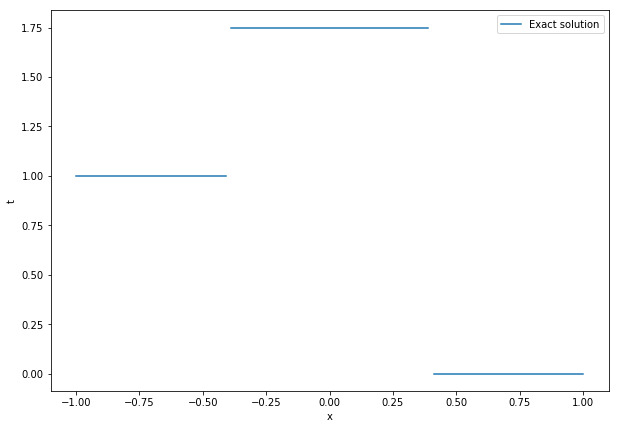

In [183]:
plt_draw(0)

## Монотонная схема с «минимальной аппроксимационной вязкостью»

$u_m ^{n+1} = 0.4 u_{m-1}^{n+1}+ 0.6 u_{m}^{n} $

In [ ]:
coef = [0.4, 0, 0.6, 0] 

## Наименее осциллирующая на разрывных решениях схема второго порядка аппроксимации

$u_m ^{n+1} = -\frac{33}{125} u_{m-1}^{n+1} + \frac{2261}{3125} u_{m-1}^{n} + \frac{1833}{3125} u_{m}^{n} -  \frac{144}{3125} u_{m+1}^{n} $

In [ ]:
coef = [-33.0/125, 2261.0/3125, 1833.0/3125, -144.0/3125]

## Гибридная схема, показавшая себя наилучшим образом при выполнении Задания №1

Гибридная схема, полученная с одновременным использованием двух схем из пункта (3п), схемы из пункта (4п) и сеточно-характеристического критерия монотонности:

\begin{equation}
 \begin{cases}
   \alpha_{-1}^{1} = -{25\over7}\alpha_{1}^{0} - {3\over7}
   \\
   \alpha_{-1}^{0} = 6\alpha_{1}^{0}  + 1
   \\
   \alpha_{0}^{0} = -{24\over7}\alpha_{1}^{0} + {3\over7}
 \end{cases}
\end{equation}

В точках __ (3/7; 0), (27/35; -0.1) __ и

$$ u_m ^{n+1} = -{1\over 4}u_{m-1}^{n+1} + {7\over 10}u_{m-1}^{n} + {3\over 5}u_{0}^{0} -{1\over 20}u_{m+1}^{n} $$

In [ ]:
coef = [[-1.0/4, 0.7, 0.6, -1.0/20], [-3.0/7, 1.0, 3.0/7, 0], [-1.0/14, 2.0/5, 27.0/35, -0.1]]